# Categorizing Trends in Science
### Arxiv Dataset
the main goal of the following project is to identify the current scientific trends by analyzing over two million scientific papers and derive the corresponding scientific sectors (i.e., the companies conducting research and development in different scientific fields) in need of high-quality data science services. This will enable the data science company subject of this report to yield rapid and consistent growth by timely targeting the right costumers. 

The data that has been used in this report to produce the necessary insight was extracted from the ArXiv dataset. The ArXiv dataset contains over two million data points (i.e., scholarly articles). Each data point is described by fourteen (14) attributes some of which will be relevant to this report and the models constructed within it. According to ArXiv, the owner of the database analyzed in this report, “for nearly 30 years, ArXiv has served the public and research communities by providing open access to scholarly articles, from the vast branches of physics to the many subdisciplines of computer science to everything in between, including math, statistics, electrical engineering, quantitative biology, and economics. This rich corpus of information offers significant, but sometimes overwhelming depth” (Cornell University, 1991). The approach that has been used to extract the scientific trends present in this massive database is a subcategory of natural language processing called topic modeling. Furthermore, the report iterates over a couple of dimensionality reduction methods that can model this non-linearly correlated vectorized data (i.e., text data represented numerically) and provide a visual representation of the clusters conformed by the related extracted topics. In the following sections, each step taken to produce the discussed results has been carefully recorded and examined to generate a complete understanding of the data and the relevant underlying topics and corresponding clusters derived from this massive data dataset.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install umap-learn
!pip install hdbscan
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=03920a1e2a27e11f9d5c864c1061a90ac6f1fc7c92ee7189880e08c58e957e0c
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=ac7ab9e85730f0413fa49ea1614b4c057b0559fe4c848f491887df42a7dd435a
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

### Arxiv Dataset

In [12]:
import dask.bag as db #dask 
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import hdbscan
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import logging # mainly use to hide or supress deprecation warnings
import umap.umap_ as umap
logging.captureWarnings(True)


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

### Loading the Data

The ArXiv dataset a is available in the json format and although the actual articles have been excluded, its size is over three (3) gigabytes. Due to the sheer amount of data present in this dataset, the loading and manipulation processes of the data are to be carefully considered, especially when using local computational resources (i.e., using a personal computer). Consequently, the data have been loaded using the Dask Framework, specifically, the Dask Bag class. Dask has optimized this class for parallel computing and proper management of multicore-capable CPUs and GPUs. Therefore, it yields much better results compared to simply loading the file using the standard JSON library. After having loaded the data successfully, the data will be filter and processed before undergoing exploratory data analysis (EDA). 

In [4]:
# Dask was developed to natively scale packages like Numpy, pandas and scikit-learn and the surrounding ecosystem to multi-core machines and distributed clusters when datasets exceed memory.
# Load data using Dask's Bag object. Which, according to my local environment, is about 3 times faster compared to loading the dataset strictly using the "json" library. 
loaded_data = db.read_text('/content/drive/MyDrive/nlp_project/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [5]:
#Check Loaded Data
print("The dataset has {} entires.".format(loaded_data.count().compute()))
print("Data Structure:")
loaded_data.take(1)

The dataset has 2258347 entires.
Data Structure:


({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

### Feature Transformations 

Before making use of the data to extract trending topics from it, it is necessary to improve the structure of the dataset to have a better representation of the underlying topics. The first step towards improving the data structure is to interpret the codified “category” attribute included in the dataset. This attribute describes each article’s main topics but has been codified into acronyms that provide little information and are not suitable for vectorization (i.e., transforming text into numerical representations). Therefore, the attribute has been interpreted and transformed into three additional features. Those features are the following: main-category, sub-category, and category description. All these newly created features are in a human-readable format (i.e., text). To generate and populate the proposed features, a function was written to extract, transform and load these fields. This function matches the acronym contained in the original “category” attribute with additional data published in the Arxiv dataset website found at https://arxiv.org/category_taxonomy. Performing this transformation will generate a quick insight into the distribution of the main categories included in the articles. Furthermore, once all this data has been vectorized and then reduced in dimensionality, the data points that share all or some main categories, sub-categories, and descriptions will be pushed together into more homogeneous clusters. The reason of all this will be further explored in the upcoming sections. 

In [6]:
#Load data extracted from the Arxiv's website
with open('/content/drive/MyDrive/nlp_project/general_topics.txt') as f:
    lines = f.readlines()

#Check first 10 lines of the data loaded to understand the patterns and structure present. 
print(*lines[:5], sep='\n')

cs.AI (Artificial Intelligence)

This category covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. 

cs.AR (Hardware Architecture)

This category covers systems organization and hardware architecture  

cs.CC (Computational Complexity)



In [7]:
#Define categories and the codes used by the original Arxiv dataset to represent these categories.
categories = {
    'computer science' : 'cs',
    'economics' : 'econ',
    'electrical engineering and system science' : 'eess',
    'mathematics' : 'math',
    'physics - astrophysics' : 'astro-ph',
    'physics - condensed matter' : 'cond-mat',
    'physics - general relativity and quantum cosmology' : 'gr-qc',
    'physics - high energy physics - experiment' : 'hep-ex',
    'high energy physics - lattice' : 'hep-lat',
    'high energy physics - phenomenology' : 'hep-ph',
    'high energy physics - theory' : 'hep-th',
    'mathematical physics' : 'math-ph',
    'physics - nonlinear sciences' : 'nlin',
    'physics - nuclear theory' : 'nucl-th',
    'physics - nuclear experiment' : 'nucl-ex', 
    'physics' : 'physics',
    'quantum physics' : 'quant-ph',
    'quantitative biology' : 'q-bio',
    'quantitative finance' : 'q-fin',
    'statistics' : 'stat',
    }

In [8]:
#Define function to structure the new loaded data (lines) from the ArXiv Website
def process_text(text):
    cleaned_list = []
    for l in text:
        if "\n" in l:
            l =  re.sub("\n", "", l)
        cleaned_list.append(l)

    pre_categories = cleaned_list[::2]
    categories_descriptions = cleaned_list[1::2]
    cleaned_list = []

    for i, v in enumerate(pre_categories):  #compress each topic with main , sub , description categories.
        topic_start = v.find('(')
        topic_end = v.find(')')
        sub_category = v[topic_start+1:topic_end].strip().lower()
        category  = (v[:topic_start]).strip().lower()
        if '.' in category:
            main_category = category[:(category.find('.'))].lower()
        else:
            main_category = category.lower()

        for k, value in categories.items():
            if value == main_category:
                main_category = k.lower()
        
        categories_description = categories_descriptions[i].strip()
        if categories_description[-1] != '.':
            categories_description = categories_description + '.'

        # (cs.ai, computer science, artificial intelligence, descripcion) Example of new data format
        new_features = (category, main_category, sub_category, categories_description)
        cleaned_list.append(new_features)
       
    return cleaned_list

cleaned_new_data = process_text(lines)

#These tuples will be used to match each category's acronym and generate newly proposed features.
print(*cleaned_new_data[:5], sep='\n')

('cs.ai', 'computer science', 'artificial intelligence', 'This category covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI.')
('cs.ar', 'computer science', 'hardware architecture', 'This category covers systems organization and hardware architecture.')
('cs.cc', 'computer science', 'computational complexity', 'This category covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in computation by abstract devices, tradeoffs among complexity measures, and formal languages, although some material in formal languages may be more appropriate for Logic in Computer Science.')
('cs.ce', 'computer science', 

### Filtering and Cleaning Data
This dataset contains 2,207,558 data points. To yield better results, the data set will be filtered down to fewer and more relevant data points. For this case study, trends have been defined as those topics that have remained relevant and investigated for at least the past four (4) years. This filtering process will be applied to the Dask Bag Object to speed up the process. Moreover, the actual transformation of the feature discussed in the previous section was run at this stage. The result was then converted into a Panda’s data frame. Finally, after running the code, the data set was reduced to 662,346 data point. Moreover, the constructed data frame contains the newly extracted features. Finally, some data types were modified to match their nature (e.g., dates were transformed into datetimes data types) and facilitate data manipulation processes.

In [9]:
# Define a function that returns the lastest year the paper was either published or updated. This function will be bases to the bag.filter() method.
def get_last(x):
    get_latest_version = int((x['versions'][-1]['created']).split(' ')[3])
    get_latest_update = int((x['update_date']).split('-')[0])
    last_date = max([get_latest_version, get_latest_update])
    return last_date
                            
# Define a function that retunrs only the relevant attributes
trim_attributes = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'versions':x['versions'],
                  'update_date':x['update_date'],}

# Filter all articles that have ramained relevant or mostly investigated for at least the past 5 years
columns = ['id','category','abstract']
loaded_data = (loaded_data.filter(lambda x: get_last(x=x) > 2019).map(trim_attributes).compute())

# convert to pandas
df = pd.DataFrame(loaded_data)

#check data frame
df.head()

,id,authors,title,category,abstract,versions,update_date
0,0704.0033,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra",Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"[physics.optics, physics.comp-ph]",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 15:34:25 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 18:21:31 GMT'}]",2022-03-31
1,0704.0038,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview and recent developments,"[physics.optics, physics.comp-ph]","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 16:25:01 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 17:39:15 GMT'}]",2022-03-30
2,0704.0275,George M. Bergman (U.C.Berkeley),Mapping radii of metric spaces,[math.MG],"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 21:53:20 GMT'}, {'version': 'v2', 'created': 'Fri, 28 Mar 2008 16:40:54 GMT'}]",2021-10-15
3,0704.0479,T.Geisser,The affine part of the Picard scheme,"[math.AG, math.KT]",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007 00:17:55 GMT'}, {'version': 'v2', 'created': 'Mon, 16 Apr 2007 04:32:14 GMT'}, {'version': 'v3', 'c...",2021-01-29
4,0704.0503,Hong-Van Le,Manifolds admitting a $\tilde G_2$-structure,"[math.AT, math.DG]",We find a necessary and sufficient condition for a compact 7-manifold to\nadmit a $\tilde G_2$-structure. As a result we find a sufficient condi...,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007 13:50:48 GMT'}, {'version': 'v2', 'created': 'Sun, 9 Aug 2009 11:27:06 GMT'}]",2023-03-06


In [10]:
#Check data frame size
df.shape

(714342, 7)

In [11]:
#Check info and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714342 entries, 0 to 714341
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           714342 non-null  object
 1   authors      714342 non-null  object
 2   title        714342 non-null  object
 3   category     714342 non-null  object
 4   abstract     714342 non-null  object
 5   versions     714342 non-null  object
 6   update_date  714342 non-null  object
dtypes: object(7)
memory usage: 38.2+ MB


In [12]:
#Check null values
df.category.isnull().sum()

0

In [13]:
#Define function to generate new features
def category_extraction(x):# extract from old categroy to main categroy
    new_category = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0]:
                new_category.append('"' + tup[1] + '"') #IMPORT TO ADD QUOTES TO THE NEW CATEGORY, OTHERWISE IS IT GOING TO BE HARD TO PERFORM EDA
                break
            elif i in tup[0]:
                new_category.append('"' + tup[1] + '"')
                break
    new_category = list(set(new_category))
    return new_category 

def subcategory_extraction(x):# extract from old categroy to sub categroy
    new_subcategory = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0]:
                new_subcategory.append('"' + tup[2] + '"')
                break
            elif i in tup[0]:
                new_subcategory.append('"' + tup[2] + '"')
                break
    new_subcategory = list(set(new_subcategory))
    return new_subcategory 

def description_extraction(x):# extract from old categroy to description categroy
    new_description = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0] and tup[3] != 'Description coming soon.':
                new_description.append(tup[3])
                break
            elif i in tup[0] and tup[3] != 'Description coming soon.':
                new_description.append(tup[3])
                break
    new_description = list(set(new_description))
    if len(new_description) > 1:
        new_description = ' Also, '.join(new_description)
    elif len(new_description) == 0:
        new_description = None
    else:
        new_description = new_description[0]

    return new_description 

def last_creation_date(x):
    last_date = (x[-1]['created']).split(' ')
    last_date = last_date[1] + ' ' + last_date[2] + ' ' + last_date[3] 
    return last_date

In [14]:
# Generate new features by traforming the old category attribute and filter data
df['new_category'] = df['category'].apply(lambda x: category_extraction(x=x))
df['sub_category'] = df['category'].apply(lambda x: subcategory_extraction(x=x))
df['description'] = df['category'].apply(lambda x: description_extraction(x=x))
df['update_date'] = pd.to_datetime(df['update_date'])
df['created_date'] = pd.to_datetime(df['versions'].apply(lambda x: last_creation_date(x=x)))
df = df.reindex(columns=['id', 'title', 'authors', 'category', 'new_category', 'sub_category', 'created_date', 'update_date', 'description', 'abstract', 'versions'])

In [15]:
pd.options.display.max_rows = 1000
df.head()

,id,title,authors,category,new_category,sub_category,created_date,update_date,description,abstract,versions
0,0704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[physics.optics, physics.comp-ph]","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 15:34:25 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 18:21:31 GMT'}]"
1,0704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[physics.optics, physics.comp-ph]","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 16:25:01 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 17:39:15 GMT'}]"
2,0704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),[math.MG],"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 21:53:20 GMT'}, {'version': 'v2', 'created': 'Fri, 28 Mar 2008 16:40:54 GMT'}]"
3,0704.0479,The affine part of the Picard scheme,T.Geisser,"[math.AG, math.KT]","[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007 00:17:55 GMT'}, {'version': 'v2', 'created': 'Mon, 16 Apr 2007 04:32:14 GMT'}, {'version': 'v3', 'c..."
4,0704.0503,Manifolds admitting a $\tilde G_2$-structure,Hong-Van Le,"[math.AT, math.DG]","[""mathematics""]","[""differential geometry"", ""algebraic topology""]",2009-08-09,2023-03-06,"This category includes complex, contact, Riemannian, pseudo-Riemannian and Finsler geometry, relativity, gauge theory, global analysis. Also, This...",We find a necessary and sufficient condition for a compact 7-manifold to\nadmit a $\tilde G_2$-structure. As a result we find a sufficient condi...,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007 13:50:48 GMT'}, {'version': 'v2', 'created': 'Sun, 9 Aug 2009 11:27:06 GMT'}]"


In [16]:
#Save filtered and cleaned data into a csv filed
df.to_csv('/content/drive/MyDrive/nlp_project/filtered_arxiv_db.csv', index = False)

### Re-Load Transformed and Cleaned Data
This step is just here to speed up the loading process in the future

In [17]:
#Load transformed data and drop non-relevant columns
df = pd.read_csv('/content/drive/MyDrive/nlp_project/filtered_arxiv_db.csv')
df[['created_date', 'update_date']] = df[['created_date', 'update_date']].apply(pd.to_datetime)
df = df.drop(['versions', 'category'], axis=1)
df.columns = ['id', 'title', 'authors', 'category', 'sub_category', 'published_date', 'updated_date', 'description', 'abstract']
df["category"] = df["category"].apply(eval)
df["sub_category"] = df["sub_category"].apply(eval)
df.head()

  df = pd.read_csv('/content/drive/MyDrive/nlp_project/filtered_arxiv_db.csv')



,id,title,authors,category,sub_category,published_date,updated_date,description,abstract
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa..."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L..."
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n
4,704.0503,Manifolds admitting a $\tilde G_2$-structure,Hong-Van Le,"[""mathematics""]","[""differential geometry"", ""algebraic topology""]",2009-08-09,2023-03-06,"This category includes complex, contact, Riemannian, pseudo-Riemannian and Finsler geometry, relativity, gauge theory, global analysis. Also, This...",We find a necessary and sufficient condition for a compact 7-manifold to\nadmit a $\tilde G_2$-structure. As a result we find a sufficient condi...


### Exploratory Data Analysis (EDA)
Moving on, to have a better understanding of the data, a basic exploratory data analysis process has been performed on the dataset in this section. After running some code, the key takeaways from this process are the following:

1.- The “description” attribute contains some null values. This is not of concern since the only purpose of this field is to be merged into the “abstract” field in the vectorization process to add and enrich the context of each article’s abstract and thus derive better clusters or groups of related articles. 

2.- The articles’ categories has been analyzed to understand how they are distributed across the dataset. For example, it has been concluded that the category with the largest number of papers is “computer science” followed by “mathematics”. Although this report is not after these categories or broader topics, from these categories a very well-rounded picture can be depicted regarding the structure of the trending topics.


In [18]:
df.isnull().sum()

id                    0
title                 0
authors               0
category              0
sub_category          0
published_date        0
updated_date          0
description       26274
abstract              0
dtype: int64

In [19]:
df.shape

(714342, 9)

In [20]:
#counting freqecy of each category 
def to_one_dimension(series):
    return pd.Series([x for _list in series for x in _list])
df_category = to_one_dimension(df['category'])
unique_value_counts = df_category.value_counts().values
unique_values = df_category.value_counts().index.to_list()

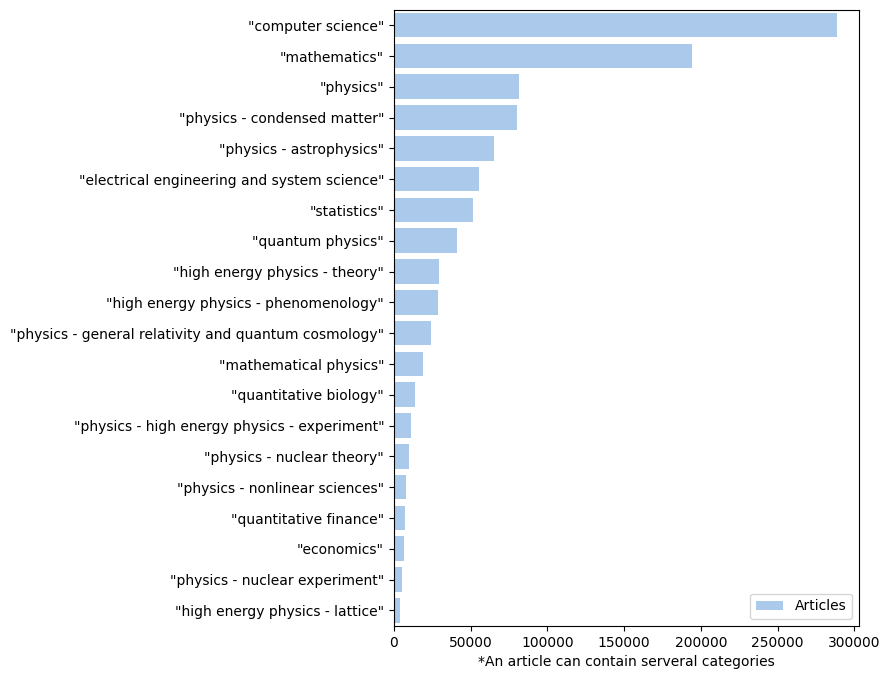

In [21]:
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes("pastel")
sns.barplot(x=unique_value_counts, y=unique_values,label="Articles", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="*An article can contain serveral categories")
plt.show()

### Feature Engineering and Clustering
Before going any further into the extraction of the trending topics comprised in this massive dataset, let's explore the methodology that was used to accomplish this goal.
In fact, topic modeling is a very large field of study within the natural language processing community.
This is because the algorithm will favor those words/topics that are less frequent across a massive number of unrelated bodies of text (i.e., abstracts).
Consequently, the algorithm will likely fail to model the topics.
This phenomenon occurs because irrelevant topics contained in small numbers of abstracts are over-represented due to their rareness relative to the large number of unrelated abstracts that don't contain them but rather contain other more common and relevant topics.
Therefore, the algorithm could erroneously discard relevant topics present in large number of related articles.
To mitigate these risks and produce a fair representation of this dataset's topics, the methodology that has been developed and implemented consists of clustering related articles before extracting any information from them.
This method enables the isolated analysis of the most relevant topics within each individual cluster.
Then, the topics relative importance to other clusters can be assessed to filter the most significant topics produced by each cluster.
There are some libraries for topic modeling that have similar approaches; however, in this case, a specific and unique implementation of the described methodology has been developed from scratch by integrating some well-known clustering, dimensionality reduction and custom-coded algorithms.
To begin modeling these clusters, the articles must be transformed into a numeric representation.
To do so, the sentence-transformers library has been used.
Sentence Transformers is a Python framework for state-of-the-art sentence, text, and image embeddings (SentenceTransformers Documentation, 2022).
This embedding method is especially strong at creating and finding semantic similarities between sentences and documents.
Thus, two pre-trained models have been tested as candidates to generate the embedding for these articles.
These models are 'allenai-specter' and "all-MiniLM-L6-v2".
The latter was trained with scientific articles and the former with general bodies of text found in sources like Wikipedia or Reddit.

In [22]:
##remove null values
df.description.fillna(value='No further description available.', inplace=True)
df.isnull().sum()

id                0
title             0
authors           0
category          0
sub_category      0
published_date    0
updated_date      0
description       0
abstract          0
dtype: int64

In [23]:
# create topic sentence that includes topics in artical  
def create_topic_sentence(categories, sub_categories):

    sentences = []
    for i, v in enumerate(categories):

        sentence = ''
        if len(v) == 1 and len(sub_categories[i]) == 1:
            sentence = f"This article's main category is {v[0]}. Some topics related to this article include: {sub_categories[i][0]}."
        elif len(v) == 1 and len(sub_categories[i]) > 1:
            sentence = f"This article's main category is {v[0]}. Some topics related to this article include: {', '.join(sub_categories[i])}."
        elif len(v) > 1 and len(sub_categories[i]) == 1:
            sentence = f"This article's main categories are {', and '.join(v)}. Some topics related to this article include: {sub_categories[i][0]}."
        else:   
            sentence = f"This article's main categories are {', and '.join(v)}. Some topics related to this article include: {', '.join(sub_categories[i])}."
        
        sentences.append(sentence.replace('"', ''))

    return pd.Series(sentences)

df['topic_sentence'] = create_topic_sentence(df['category'].to_list(), df['sub_category'].to_list())
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: optics, computational physics."
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: optics, computational physics."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry."
4,704.0503,Manifolds admitting a $\tilde G_2$-structure,Hong-Van Le,"[""mathematics""]","[""differential geometry"", ""algebraic topology""]",2009-08-09,2023-03-06,"This category includes complex, contact, Riemannian, pseudo-Riemannian and Finsler geometry, relativity, gauge theory, global analysis. Also, This...",We find a necessary and sufficient condition for a compact 7-manifold to\nadmit a $\tilde G_2$-structure. As a result we find a sufficient condi...,"This article's main category is mathematics. Some topics related to this article include: differential geometry, algebraic topology."


In [24]:
#combing abstract, topic_sentence , description
df['unifed_text'] = df['abstract'] + '[SEP]' + df['topic_sentence'] + '[SEP]' + df['description'] + '[SEP]'
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence,unifed_text
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: optics, computational physics.",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: optics, computational physics.","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa..."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.,"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L..."
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry.",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n[SEP]This article'...
4,704.0503,Manifolds admitting a $\tilde G_2$-structure,Hong-Van Le,"[""mathematics""]","[""differential geometry"", ""algebraic topology""]",2009-08-09,2023-03-06,"This category includes complex, contact, Riemannian, pseudo-Riemannian and Finsler geometry, relativity, gauge theory, global analysis. Also, This...",We find a necessary and sufficient condition for a compact 7-manifold to\nadmit a $\tilde G_2$-structure. As a result we find a sufficient condi...,"This article's main category is mathematics. Some topics related to this article include: differential geometry, algebraic topology.",We find a necessary and sufficient condition for a compact 7-manifold to\nadmit a $\tilde G_2$-structure. As a result we find a sufficient condi...


In [25]:
def _preprocess_text(documents):
        
        """ Basic preprocessing of documents:

        Steps:
            * Replace \n and \t with whitespace
            * Only keep alpha-numerical characters
            * Lower case words and tokenization
        """
        
        cleaned_documents = [doc.replace("\n", " ") for doc in documents]
        cleaned_documents = [doc.replace("\t", " ") for doc in cleaned_documents]
        cleaned_documents = [re.sub(' +', ' ', doc) for doc in cleaned_documents]
        cleaned_documents = [doc.strip() for doc in cleaned_documents]
        #cleaned_documents = [re.sub(r'[^A-Za-z0-9 ]+', '', doc) for doc in cleaned_documents]
        #cleaned_documents = [gensim.utils.simple_preprocess(doc) for doc in cleaned_documents]
        return cleaned_documents

In [26]:
df = df.assign(text=_preprocess_text(df['unifed_text'].to_list()))
df = df.assign(title=_preprocess_text(df['title'].to_list()))
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence,unifed_text,text
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: optics, computational physics.",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,We performed a rigorous theoretical convergence analysis of the discrete dipole approximation (DDA). We prove that errors in any measured quantity...
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""optics"", ""computational physics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: optics, computational physics.","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","We present a review of the discrete dipole approximation (DDA), which is a general method to simulate light scattering by arbitrarily shaped parti..."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.,"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","It is known that every closed curve of length \leq 4 in R^n (n>0) can be surrounded by a sphere of radius 1, and that this is the best bound. Lett..."
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry.",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n[SEP]This article'...,We describe the maximal torus and maximal unipotent subgroup of the Picard variety of a proper scheme over a perfect field. [SEP]This article's ma...
4,704.0503,Manifolds admitting a $\tilde G_2$-structure,Hong-Van Le,"[""mathematics""]","[""differential geometry"", ""algebraic topology""]",2009-08-09,2023-03-06,"This category includes complex, contact, Riemannian, pseudo-Riemannian and Finsler geometry, relativity, gauge theory, global analysis. Also, This...",We

In [30]:
df1 = df.sample(frac = 0.01)

In [31]:
# create enhanced abstracts
articles_text = ['[CLS]' + article[0] + '[SEP]' + article[1] for article in zip(df1['title'].to_list(), df1['text'].to_list())]
articles_text[:10]

['[CLS]Reconfigurable Intelligent Surface Aided Amplitude- and Phase-Modulated Downlink Transmission[SEP]New reconfigurable intelligent surface (RIS) based amplitude and phase modulation schemes are proposed as an evolution how the phase-only modulation schemes available in the literature. Explicitly, both the amplitude-phase shift keying (A-PSK) and quadrature amplitude-phase shift keying (QA-PSK) are conceived, where the RIS is assumed to be part of a transmitter to deliver information to the multi-antenna aided downlink receiver. In the proposed design, the RIS is partitioned into multiple blocks, and the information bits are conveyed by controlling both the ON-OFF state and the phase shift of the RIS elements in each block. Since the propagation paths spanning from each RIS block to the receiver can be coherently combined as a benefit of appropriately configuring the phase of the RIS elements, the received signal constellations can be designed by controlling both the ON-OFF pattern

In [32]:
# fit the data in tranformer
model = SentenceTransformer('allenai-specter')
corpus_embeddings = model.encode(articles_text, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/224 [00:00<?, ?it/s]

In [ ]:
#Backup cell

# np.save('embeddings.npy',corpus_embeddings)
# corpus_embeddings_np = np.load('embeddings.npy',allow_pickle=True)

In [ ]:
# corpus_embeddings_np.shape

In [33]:
#Don't run if backup has been run
corpus_embeddings_np = corpus_embeddings.cpu().numpy().astype(np.float64)

In [34]:
# dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings_np)
umap_embeddings

array([[ 9.218161  ,  5.707529  ,  4.8738985 ,  2.8430817 ,  1.1389076 ],
       [ 8.943844  ,  6.538682  ,  2.5896275 ,  2.0299037 ,  0.5550696 ],
       [ 9.74667   ,  5.8011546 ,  3.7447264 ,  1.3709065 ,  0.14233033],
       ...,
       [10.9577675 ,  7.4508867 ,  1.8745399 ,  2.5145442 ,  0.5797406 ],
       [ 6.446485  ,  4.4317884 ,  2.0145817 ,  2.507108  ,  0.6356814 ],
       [ 8.173669  ,  6.4946394 ,  2.2248645 ,  2.3448544 ,  0.43755302]],
      dtype=float32)

In [35]:
#clustring using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
clusterer.fit(umap_embeddings)

HDBSCAN(min_cluster_size=200, prediction_data=True)

In [36]:
np.max(clusterer.labels_)

2

In [38]:
df1['hdbscan_cluster'] = clusterer.labels_
df1.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence,unifed_text,text,hdbscan_cluster
649475,2301.09717,Reconfigurable Intelligent Surface Aided Amplitude- and Phase-Modulated Downlink Transmission,"Qingchao Li, Mohammed El-Hajjar, Ibrahim Hemadeh, Arman Shojaeifard,\n Alain A. M. Mourad, Lajos Hanzo","[""electrical engineering and system science"", ""mathematics"", ""computer science""]","[""information theory"", ""signal processing""]",2023-01-23,2023-01-25,"This category covers theoretical and experimental aspects of information theory and coding. Also, This category includes theory, algorithms, perfo...",New reconfigurable intelligent surface (RIS) based amplitude and phase\nmodulation schemes are proposed as an evolution how the phase-only modul...,"This article's main categories are electrical engineering and system science, and mathematics, and computer science. Some topics related to this a...",New reconfigurable intelligent surface (RIS) based amplitude and phase\nmodulation schemes are proposed as an evolution how the phase-only modul...,New reconfigurable intelligent surface (RIS) based amplitude and phase modulation schemes are proposed as an evolution how the phase-only modulati...,1
349426,2106.02968,Low Budget Active Learning via Wasserstein Distance: An Integer Programming Approach,"Rafid Mahmood, Sanja Fidler, Marc T. Law","[""mathematics"", ""computer science""]","[""machine learning"", ""optimization and control""]",2023-03-07,2023-03-08,"This category includes operations research, linear programming, control theory, systems theory, optimal control, game theory. Also, This category ...",Active learning is the process of training a model with limited labeled data\nby selecting a core subset of an unlabeled data pool to label. The...,"This article's main categories are mathematics, and computer science. Some topics related to this article include: machine learning, optimization ...",Active learning is the process of training a model with limited labeled data\nby selecting a core subset of an unlabeled data pool to label. The...,Active learning is the process of training a model with limited labeled data by selecting a core subset of an unlabeled data pool to label. The la...,1
639808,2301.0005,Long-Term Online Multi-Session Graph-Based SPLAM with Memory Management,Mathieu Labb\'e and Fran\c{c}ois Michaud,"[""computer science""]","[""robotics""]",2022-12-30,2023-01-03,No further description available.,"For long-term simultaneous planning, localization and mapping (SPLAM), a\nrobot should be able to continuously update its map according to the d...",This article's main category is computer science. Some topics related to this article include: robotics.,"For long-term simultaneous planning, localization and mapping (SPLAM), a\nrobot should be able to continuously update its map according to the d...","For long-term simultaneous planning, localization and mapping (SPLAM), a robot should be able to continuously update its map according to the dyna...",1
27473,1808.0333,On sound ranging in proper metric spaces,Sergij V. Goncharov,"[""mathematics""]","[""metric geometry"", ""functional analysis""]",2018-08-09,2021-03-16,"This category includes banach spaces, function spaces, real functions, integral transforms, theory of distributions, measure theory. Also, This ca...","We consider the sound ranging, or source localization, problem - find the\nsource-point from the moments when the wave-sphere of linearly, with ...","This article's main category is mathematics. Some topics related to this article include: metric geometry, functional analysis.","We consider the sound ranging, or source localization, problem - find the\nsource-point from the moments when the wave-sphere of linearly, with ...","We consider the sound ranging, or source localization, problem - find the source-point from the moments when the wave-sphere of linearly, with tim...",2
426307,2111.0351,Wright f

In [8]:
df1[df1.hdbscan_cluster == -1]['id'].count()

NameError: ignored

In [9]:
# Save clustered data into a CVS file
df1.to_csv('/content/drive/MyDrive/nlp_project/clustered_arxiv_db2.csv', index = False)

NameError: ignored

### Re-Load Clustered Data
This step is just here to speed up the loading process in the future

In [15]:
#Load transformed data and drop non-relevant columns
df = pd.read_csv('/content/drive/MyDrive/nlp_project/clustered_arxiv_db2.csv')
df[['published_date', 'updated_date']] = df[['published_date', 'updated_date']].apply(pd.to_datetime)
df["category"] = df["category"].apply(eval)
df["sub_category"] = df["sub_category"].apply(eval)
df = df.drop(['description', 'topic_sentence', 'unifed_text', 'text', 'authors'], axis=1)
df = df[df.hdbscan_cluster != -1]
df.head()

,id,title,category,sub_category,published_date,updated_date,abstract,hdbscan_cluster
0,2301.09717,Reconfigurable Intelligent Surface Aided Amplitude- and Phase-Modulated Downlink Transmission,"[""electrical engineering and system science"", ""mathematics"", ""computer science""]","[""information theory"", ""signal processing""]",2023-01-23,2023-01-25,New reconfigurable intelligent surface (RIS) based amplitude and phase\nmodulation schemes are proposed as an evolution how the phase-only modul...,1
1,2106.02968,Low Budget Active Learning via Wasserstein Distance: An Integer Programming Approach,"[""mathematics"", ""computer science""]","[""machine learning"", ""optimization and control""]",2023-03-07,2023-03-08,Active learning is the process of training a model with limited labeled data\nby selecting a core subset of an unlabeled data pool to label. The...,1
2,2301.0005,Long-Term Online Multi-Session Graph-Based SPLAM with Memory Management,"[""computer science""]","[""robotics""]",2022-12-30,2023-01-03,"For long-term simultaneous planning, localization and mapping (SPLAM), a\nrobot should be able to continuously update its map according to the d...",1
3,1808.0333,On sound ranging in proper metric spaces,"[""mathematics""]","[""metric geometry"", ""functional analysis""]",2018-08-09,2021-03-16,"We consider the sound ranging, or source localization, problem - find the\nsource-point from the moments when the wave-sphere of linearly, with ...",2
4,2111.0351,Wright functions of the second kind and Whittaker functions,"[""mathematics""]","[""general mathematics""]",2022-07-05,2022-07-07,In the framework of higher transcendental functions the Wright functions of\nthe second kind have increased their relevance resulting from their...,2


In [16]:
df.shape

(7009, 8)

### Topic Modeling
In this final section, the trending topics are extracted.
To do so, the clusters will first be analyzed in isolation from each other.
As a result, the most relevant topics within each cluster should emerge from this process.
To begin, it is necessary to pre-process all the abstracts.
Although we had created an enhanced version of the abstract, the raw or original abstract will be used at this stage since the enhancements sole purpose was to enrich the context within each original abstract in order to produce better clusters.
At this point, all words were lemmatized.
Once all abstracts have been processed, the Count-Vectorizer class available in the Sci-Kit learn library was used to extract the occurring frequency of each word within each cluster.
The array returned by the fit_tranformed method of this class was then normalized using the l1 norm to account for the differences in the size of the different clusters.
Finally, this data was transformed into a data frame where each row is a cluster, and each column is a word.
The values in this data frame correspond to the normalized counts of occurrences of each word within each cluster.
To calculate these values, all the abstracts belonging to a given cluster were joined together and individually processed.
The result is a sparse matrix.
Following, the importance of each word within each cluster was assessed relative to all other clusters.
To do so, the TF-IDF score for each word was calculated.
The clusters were considered as if they were a single body of text.
Therefore, the data frame constructed contains clusters as rows, words as columns, and normalized values that reflect the importance of each word contained in a given cluster relative to all other clusters.
Finally, to assess the overall importance of a topic, the importance of a word within a cluster (i.e., the normalized counts returned by the Count-Vectorizer class) was transformed by applying a weight to it.
In this case, the weight corresponds to the TF-IDF score of that same word within the cluster and relative to all other clusters.
For this dataset, the best results for this transformation came from simply multiplying these two values.
However, it is worth mentioning that other transformations could be explored.

In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stopwords = stopwords.words('english')
wl = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def _preprocess_cluster(document):
        
        """ Basic preprocessing of documents:

        Steps:
            * Replace \n and \t with whitespace
            * Only keep alpha-numerical characters
            * Lower case words and tokenization
            * lemmatization
        """
        
        cleaned_document = document.replace("\n", " ") 
        cleaned_document = cleaned_document.replace("\t", " ")
        cleaned_document = cleaned_document.strip() 
        cleaned_document = re.sub(r'[^A-Za-z0-9 ]+', '', cleaned_document) 
        cleaned_document = ''.join([char.lower() for char in cleaned_document if char not in string.punctuation])
        tokens = re.split('\W+', cleaned_document)
        tokens = [wl.lemmatize(word) for word in tokens if word not in stopwords]
        return tokens

In [21]:
nltk.download('wordnet')
df['title'] = df['title'].apply(lambda x: _preprocess_cluster(x))
df['abstract'] = df['abstract'].apply(lambda x: _preprocess_cluster(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,id,title,category,sub_category,published_date,updated_date,abstract,hdbscan_cluster,cand_topics
0,2301.09717,"[reconfigurable, intelligent, surface, aided, amplitude, phasemodulated, downlink, transmission]","[""electrical engineering and system science"", ""mathematics"", ""computer science""]","[""information theory"", ""signal processing""]",2023-01-23,2023-01-25,"[new, reconfigurable, intelligent, surface, ri, based, amplitude, phase, modulation, scheme, proposed, evolution, phaseonly, modulation, scheme, a...",1,R e c o n f i g u r a b l e I n t e l l i g e n t S u r f a c e A i d e d A m p l i t u d e - a n d P h a s e - M o d u l a t e d D ...
1,2106.02968,"[low, budget, active, learning, via, wasserstein, distance, integer, programming, approach]","[""mathematics"", ""computer science""]","[""machine learning"", ""optimization and control""]",2023-03-07,2023-03-08,"[active, learning, process, training, model, limited, labeled, data, selecting, core, subset, unlabeled, data, pool, label, large, scale, data, se...",1,L o w B u d g e t A c t i v e L e a r n i n g v i a W a s s e r s t e i n D i s t a n c e : A n I n t e g e r P r o g r a m m i ...
2,2301.0005,"[longterm, online, multisession, graphbased, splam, memory, management]","[""computer science""]","[""robotics""]",2022-12-30,2023-01-03,"[longterm, simultaneous, planning, localization, mapping, splam, robot, able, continuously, update, map, according, dynamic, change, environment, ...",1,L o n g - T e r m O n l i n e M u l t i - S e s s i o n G r a p h - B a s e d S P L A M w i t h M e m o r y M a n a g e m e n t ...
3,1808.0333,"[sound, ranging, proper, metric, space]","[""mathematics""]","[""metric geometry"", ""functional analysis""]",2018-08-09,2021-03-16,"[consider, sound, ranging, source, localization, problem, find, sourcepoint, moment, wavesphere, linearly, time, increasing, radius, reach, sensor...",2,"O n s o u n d r a n g i n g i n p r o p e r m e t r i c s p a c e s W e c o n s i d e r t h e s o u n d r a n g i n g , ..."
4,2111.0351,"[wright, function, second, kind, whittaker, function]","[""mathematics""]","[""general mathematics""]",2022-07-05,2022-07-07,"[framework, higher, transcendental, function, wright, function, second, kind, increased, relevance, resulting, application, probability, theory, p...",2,W r i g h t f u n c t i o n s o f t h e s e c o n d k i n d a n d W h i t t a k e r f u n c t i o n s I n t h e f r a m e ...


In [22]:
df['cand_topics'] = df['title'] + df['abstract']
df['cand_topics'] = df['cand_topics'].apply(lambda x: ' '.join(x))
df.head()

,id,title,category,sub_category,published_date,updated_date,abstract,hdbscan_cluster,cand_topics
0,2301.09717,"[reconfigurable, intelligent, surface, aided, amplitude, phasemodulated, downlink, transmission]","[""electrical engineering and system science"", ""mathematics"", ""computer science""]","[""information theory"", ""signal processing""]",2023-01-23,2023-01-25,"[new, reconfigurable, intelligent, surface, ri, based, amplitude, phase, modulation, scheme, proposed, evolution, phaseonly, modulation, scheme, a...",1,reconfigurable intelligent surface aided amplitude phasemodulated downlink transmission new reconfigurable intelligent surface ri based amplitude ...
1,2106.02968,"[low, budget, active, learning, via, wasserstein, distance, integer, programming, approach]","[""mathematics"", ""computer science""]","[""machine learning"", ""optimization and control""]",2023-03-07,2023-03-08,"[active, learning, process, training, model, limited, labeled, data, selecting, core, subset, unlabeled, data, pool, label, large, scale, data, se...",1,low budget active learning via wasserstein distance integer programming approach active learning process training model limited labeled data selec...
2,2301.0005,"[longterm, online, multisession, graphbased, splam, memory, management]","[""computer science""]","[""robotics""]",2022-12-30,2023-01-03,"[longterm, simultaneous, planning, localization, mapping, splam, robot, able, continuously, update, map, according, dynamic, change, environment, ...",1,longterm online multisession graphbased splam memory management longterm simultaneous planning localization mapping splam robot able continuously ...
3,1808.0333,"[sound, ranging, proper, metric, space]","[""mathematics""]","[""metric geometry"", ""functional analysis""]",2018-08-09,2021-03-16,"[consider, sound, ranging, source, localization, problem, find, sourcepoint, moment, wavesphere, linearly, time, increasing, radius, reach, sensor...",2,sound ranging proper metric space consider sound ranging source localization problem find sourcepoint moment wavesphere linearly time increasing r...
4,2111.0351,"[wright, function, second, kind, whittaker, function]","[""mathematics""]","[""general mathematics""]",2022-07-05,2022-07-07,"[framework, higher, transcendental, function, wright, function, second, kind, increased, relevance, resulting, application, probability, theory, p...",2,wright function second kind whittaker function framework higher transcendental function wright function second kind increased relevance resulting ...


In [23]:
data = {}
clusters_indx = df['hdbscan_cluster'].unique()
for indx in clusters_indx:
    data[indx] = ' '.join(df[df.hdbscan_cluster == indx]['cand_topics'].to_list())
#Remove cluster 0 with 121966 data points
data.pop(0)
df_clusters = pd.Series(data)
df_clusters.head()

1    reconfigurable intelligent surface aided amplitude phasemodulated downlink transmission new reconfigurable intelligent surface ri based amplitude ...
2    sound ranging proper metric space consider sound ranging source localization problem find sourcepoint moment wavesphere linearly time increasing r...
dtype: object

In [24]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df_clusters)
x = normalize(x.toarray(), norm='l1')
bag_df = pd.DataFrame(x, columns=vectorizer.get_feature_names_out(), index=df_clusters.index)
bag_df.head()

,00,000,0001,000194,0002x002,0004,0005,0007,0008,001,...,zwedgel,zwith,zxb1,zxcalculus,zxy,zygmund,zyleq,zyx,zz1z2t,zznbig
1,0.000000,0.000012,0.000006,0.000003,0.000000,0.000003,0.000000,0.000003,0.000003,0.000006,...,0.000000,0.000000,0.000003,0.000000,0.000003,0.000000,0.000000,0.000000,0.000003,0.000000
2,0.000016,0.000016,0.000008,0.000000,0.000004,0.000000,0.000004,0.000000,0.000000,0.000025,...,0.000004,0.000004,0.000000,0.000008,0.000000,0.000008,0.000004,0.000008,0.000000,0.000004


In [25]:
cluster_count = df.groupby('hdbscan_cluster').count()
cluster_count = pd.Series(cluster_count['id'])
cluster_count.head()

hdbscan_cluster
0    1262
1    2924
2    2823
Name: id, dtype: int64

In [26]:
tfidf_vect_gen = TfidfVectorizer(input='content', norm='l1')
x_tfidf = tfidf_vect_gen.fit_transform(df_clusters)
x_tfidf = normalize(x_tfidf.toarray(), norm='l1')
x_tfidf_df = pd.DataFrame(x_tfidf, columns=tfidf_vect_gen.get_feature_names_out(), index=df_clusters.index)
x_tfidf_df.head()

,00,000,0001,000194,0002x002,0004,0005,0007,0008,001,...,zwedgel,zwith,zxb1,zxcalculus,zxy,zygmund,zyleq,zyx,zz1z2t,zznbig
1,0.000000,0.000011,0.000006,0.000004,0.000000,0.000004,0.000000,0.000004,0.000004,0.000006,...,0.000000,0.000000,0.000004,0.000000,0.000004,0.000000,0.000000,0.000000,0.000004,0.000000
2,0.000022,0.000015,0.000008,0.000000,0.000005,0.000000,0.000005,0.000000,0.000000,0.000023,...,0.000005,0.000005,0.000000,0.000011,0.000000,0.000011,0.000005,0.000011,0.000000,0.000005


In [27]:
def get_topics (df_main: pd.DataFrame, df_clus: pd.Series):
    clusters_indx = df_clus.index.to_list()
    topics = {}
    weights = {}
    for indx in clusters_indx:

        bag_series = pd.Series(df_main.loc[indx])
        temp_series = pd.Series(df_clus.loc[indx])
        topics_weights = bag_series.multiply (temp_series)
        series_temp = topics_weights.sort_values(ascending=False).head(10)
        topics[indx] = series_temp.index.to_list()
        weights[indx] = series_temp.to_list()


    return topics, weights

In [28]:
topics, weights = get_topics(bag_df, x_tfidf_df)
topics = pd.Series(topics)
weights = pd.Series(weights)

In [29]:
topics
#Old cell ran with cluster 0 

1    [model, method, data, learning, network, system, approach, using, problem, algorithm]
2          [quantum, system, result, model, show, state, problem, method, equation, study]
dtype: object

In [30]:
topics

1    [model, method, data, learning, network, system, approach, using, problem, algorithm]
2          [quantum, system, result, model, show, state, problem, method, equation, study]
dtype: object

### Conclusion
The following table illustrates the topics extracted. There is certainly room for improvement by testing different hyperparameters, data structures, and transformations. Moreover, if one would like to provide more context to the topics, using n-gram vectorizing algorithms could help understand the context of the topics. N-grams algorithms consider n number of words before and after each given word and return the frequency of occurrences of those given phrases. Nonetheless, this method has yielded a very good understanding of the governing topics. The following table is color-coded for possibly related topics. 

To conclude, the topics generated seem to be very relevant in modern times. For example, topics such as artificial intelligence, tensors, code, and blockchain are surely areas of great public interest. Some words were manually removed from the final top 100 list because they are generic words (e.g., dialogue, opinion, game, group) that without the proper context, little inference can be extracted from them. Topic modeling is a complex task with many possible implementations. Nonetheless, the topics extracted here will certainly be a good starting point for any data science business.   

In [31]:
df_final = pd.concat([cluster_count, topics, weights], axis= 1)
df_final = df_final[df_final.index != 0]
df_final.columns = ['count', 'topics', 'weights']
df_final['cluster_size'] = df_final['count'].apply(lambda x: x / df_final['count'].sum())
df_final.head()

,count,topics,weights,cluster_size
1,2924,"[model, method, data, learning, network, system, approach, using, problem, algorithm]","[0.00013015644581995276, 6.577184908533385e-05, 5.2467863844267e-05, 4.532485933430904e-05, 4.485149590111446e-05, 2.314914915522271e-05, 2.059511...",0.508787
2,2823,"[quantum, system, result, model, show, state, problem, method, equation, study]","[4.584377604459095e-05, 2.8927749895060893e-05, 2.778388849169118e-05, 2.309378611943851e-05, 2.166371802422275e-05, 1.711701177222538e-05, 1.3047...",0.491213


In [32]:
# final topics
all_topics = [ x for l in df_final['topics'].to_list() for x in l]
all_weights = [ x for l in df_final['weights'].to_list() for x in l]
final_topics = pd.Series(all_weights)
final_topics.index = all_topics
final_topics = final_topics.groupby(level=0).mean()
final_topics.sort_values(ascending=False).head(100)

model        0.000077
data         0.000052
quantum      0.000046
learning     0.000045
network      0.000045
method       0.000039
result       0.000028
system       0.000026
show         0.000022
approach     0.000021
using        0.000020
algorithm    0.000019
state        0.000017
problem      0.000016
equation     0.000013
study        0.000012
dtype: float64